In [1]:
import sys
sys.path.insert(0,'C:\\code\\masters_thesis\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

"""
Load relevant packages
"""

import numpy as np
import pandas as pd
import requests
import random
import bs4 as bs
import datetime
import yfinance as yf
# from pandas_datareader import data as pdr
# from pandas_datareader.data import DataReader
from pandas_datareader.famafrench import FamaFrenchReader
from pandas_datareader.yahoo.daily import YahooDailyReader
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import minimize
import array_to_latex as a2l

"""
Own packages
"""

# from codelib.statistics.moments import corr_to_cov_matrix
from codelib.population_parameters import calculate_mean, calculate_cov_mat
from codelib.portfolio_measures import portfolio_mean, portfolio_variance, portfolio_std
from codelib.portfolio_performance_measures import sharpe_ratio

# Afkastforventninger.dk
afkastforventinger 1H2023 for forskellige investeringsklasser på kort sigt (1-5 år)

In [40]:
corr_mat = np.array([[1.0,0.6,0.1,0.3,-0.1,-0.1,-0.2,-0.1,-0.1,-0.1],
[0.6,1.0,0.6,0.6,0.2,0.2,0.2,0.1,0.1,0.3],
[0.1,0.6,1.0,0.7,0.7,0.6,0.6,0.4,0.3,0.7],
[0.3,0.6,0.7,1.0,0.5,0.6,0.4,0.2,0.2,0.5],
[-0.1,0.2,0.7,0.5,1.0,0.7,0.8,0.4,0.4,0.8],
[-0.1,0.2,0.6,0.6,0.7,1.0,0.7,0.4,0.4,0.7],
[-0.2,0.2,0.6,0.4,0.8,0.7,1.0,0.4,0.4,0.7],
[-0.1,0.1,0.4,0.2,0.4,0.4,0.4,1.0,0.3,0.4],
[-0.1,0.1,0.3,0.2,0.4,0.4,0.4,0.3,1.0,0.4],
[-0.1,0.3,0.7,0.5,0.8,0.7,0.7,0.4,0.4,1.0]])
vols = np.array([0.037, 0.055, 0.119, 0.107, 0.153, 0.217, 0.204, 0.14, 0.108, 0.094]) #std.
returns_yearly = np.array([0.019, 0.022, 0.049, 0.043, 0.061, 0.083, 0.102, 0.056, 0.041, 0.038]) #linear returns
assets = ["GB","IGB","HYB","EMGB","EDM","EEM","PE","IS","RE","HF"]

# Population parameters (from T historical observations)

In [521]:
# choose dataset
monthly_returns = pd.read_csv(r'C:\code\masters_thesis\data\10industry_mc_monthly_returns.csv', index_col='Date')
#monthly_returns = pd.read_csv(r'C:\code\masters_thesis\data\10industry_mc_monthly_returnpremiums.csv', index_col='Date')
rf_returns = pd.read_csv(r'C:\code\masters_thesis\data\us_onemonth_tbill_returns.csv', index_col='Date')

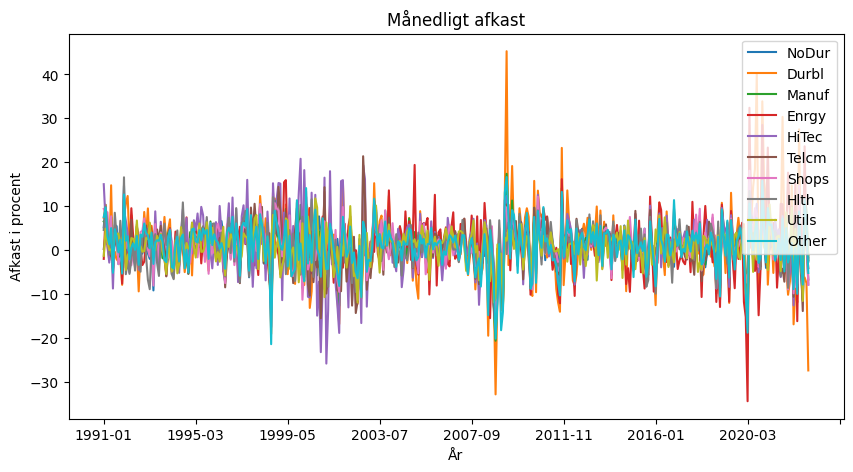

In [522]:
# plot monthly returns
ax = monthly_returns.plot(title="Månedligt afkast", figsize=(10, 5), xlabel="År");
ax.set_ylabel('Afkast i procent');

In [523]:
# calculate population parameters mu and sigma and r^f: here mean returns and covariance matrix of returns
rf = np.mean(rf_returns['RF'])
print(rf)
mu = np.mean(monthly_returns, axis=0)
print(mu)
cov_mat = np.cov(monthly_returns.T) #normalized by N-1 by default
print(cov_mat)

0.19492187500000002
NoDur    0.917526
Durbl    1.039948
Manuf    1.033411
Enrgy    1.007786
HiTec    1.219792
Telcm    0.686927
Shops    1.011354
Hlth     1.001016
Utils    0.848411
Other    0.947917
dtype: float64
[[14.40494086 15.25948603 13.52843849 11.78612689 11.70040027 11.60171092
  12.00714435 10.81756335  8.46766708 14.40987186]
 [15.25948603 64.99404908 28.89449261 23.82833957 33.00569007 22.11792464
  25.92776743 15.04040214 10.19176676 30.58323018]
 [13.52843849 28.89449261 23.42476718 20.02366188 22.95702761 16.68074994
  17.28174994 12.95224457  9.09454643 22.02839694]
 [11.78612689 23.82833957 20.02366188 43.54342668 16.87355411 15.33748717
  12.2815863  10.36382889 12.66384608 19.82569355]
 [11.70040027 33.00569007 22.95702761 16.87355411 46.22298481 22.93724296
  21.70463762 15.47163233  6.0843558  22.90047293]
 [11.60171092 22.11792464 16.68074994 15.33748717 22.93724296 25.79297696
  15.16031331 12.05348433  8.16584915 18.57862256]
 [12.00714435 25.92776743 17.281749

# Population parameters from afkastforventninger.dk

In [524]:
# calculate monthly distribution parameters from yearly log-norm params...

"""
Antag log-afkast er normalfordelt, find parametre for 1 måned.
Find lineære afkastparametre og bestem optimal portefølje for dem.
Simulér log-afkast og estimer mu og Sigma udfra population mean and covariance. Transformer parametre til lineært afkast og optimer på hver simulation..
"""

'\nAntag log-afkast er normalfordelt, find parametre for 1 måned.\nFind lineære afkastparametre og bestem optimal portefølje for dem.\nSimulér log-afkast og estimer mu og Sigma udfra population mean and covariance. Transformer parametre til lineært afkast og optimer på hver simulation..\n'

# Max sharpe portfolio (true optimal)

In [525]:
# find optimal MV portfolio (max sharpe)
#rf = 0

# define constraints: sum-to-one and long-only
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1, 'jac' : lambda w: np.ones_like(w)},
               {'type': 'ineq', 'fun' : lambda w: w, 'jac' : lambda w: np.eye(len(w))})

# set initial value
equal_weights = np.ones_like(mu) / len(mu)

res = minimize(fun = sharpe_ratio, args=(mu, cov_mat, rf),
               x0 = equal_weights,
               method = 'SLSQP',
               constraints = constraints,
               options={'ftol': 1e-9, 'disp': True})
w_m = res.x
print(np.round(w_m,4))

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.22339126898501993
            Iterations: 16
            Function evaluations: 176
            Gradient evaluations: 16
[ 0.1988  0.     -0.      0.0069  0.0945 -0.      0.1482  0.2493  0.3024
 -0.    ]


In [526]:
# calculate expected return, variance, std. and Sharpe-ratio for the true optimal MV portfolio

mu_m = portfolio_mean(w_m, mu)
print("mu_m = " + str(mu_m))
var_m = portfolio_variance(w_m, cov_mat)
print("sigma^2_m = " + str(var_m))
std_m = portfolio_std(w_m, cov_mat)
print("sigma_m = " + str(std_m))
sr_m = (mu_m - rf) / std_m
print("SR_m = " + str(sr_m))

mu_m = 0.9605332323570296
sigma^2_m = 11.745847129649375
sigma_m = 3.4272214882685033
SR_m = 0.22339126898501993


In [527]:
# simulate returns for (num_obs) t=60

#rf = 0
num_sim = 500
num_obs = 60 # months
np.random.seed(2)
sim_data = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_obs))

mu_est = np.mean(sim_data, axis=1)
w_sim = list()

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1, 'jac' : lambda w: np.ones_like(w)},
               {'type': 'ineq', 'fun' : lambda w: w, 'jac' : lambda w: np.eye(len(w))})

equal_weights = np.ones_like(mu) / len(mu)

for i in range(num_sim):

    cov_mat_est = np.cov(sim_data[i], rowvar=False)

    res = minimize(fun = sharpe_ratio, args=(mu_est[i], cov_mat_est, rf),
                   x0 = equal_weights,
                   method = 'SLSQP',
                   constraints = constraints)
    w_sim.append(res.x)

w_sim = np.array(w_sim)

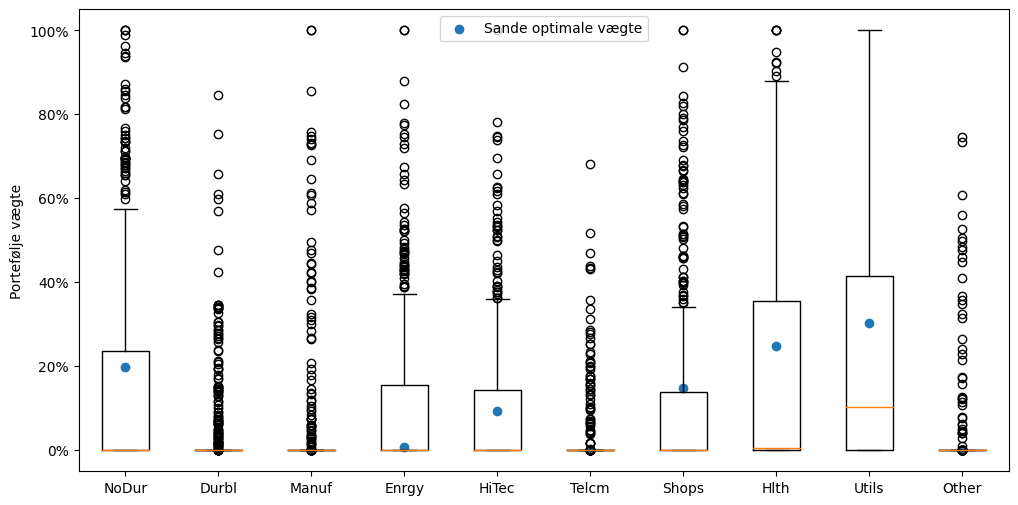

In [530]:
# boxplot of simulated optimal portfolio weights

fig, ax = plt.subplots(figsize=(12, 6))

ax.boxplot(w_sim);

ax.set_xticklabels(assets)
ax.scatter(np.arange(len(w_m)) + 1, w_m, label="Sande optimale vægte")

ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

ax.legend();
ax.set_ylabel("Portefølje vægte")
plt.savefig("boxplot_optimal_weights.jpg",bbox_inches="tight",dpi=300)
plt.show()

In [531]:
# calculate ESTIMATED expected portfolio returns, std. and variances for simulated MV portfolios

mu_sim_est = list()
var_sim_est = list()

for i in range (num_sim):
    mean = portfolio_mean(w_sim[i], mu_est[i])
    cov_mat_est = np.cov(sim_data[i], rowvar=False)
    var = portfolio_variance(w_sim[i], cov_mat_est)
    mu_sim_est.append(mean)
    var_sim_est.append(var)

std_sim_est = np.sqrt(var_sim_est)

In [532]:
# calculate ACTUAL expected portfolio returns, std. and variance for the simulated MV portfolios

mu_sim = list()
var_sim = list()

for i in range (num_sim):
    mean = portfolio_mean(w_sim[i], mu)
    var = portfolio_variance(w_sim[i], cov_mat)
    mu_sim.append(mean)
    var_sim.append(var)

std_sim = np.sqrt(var_sim)

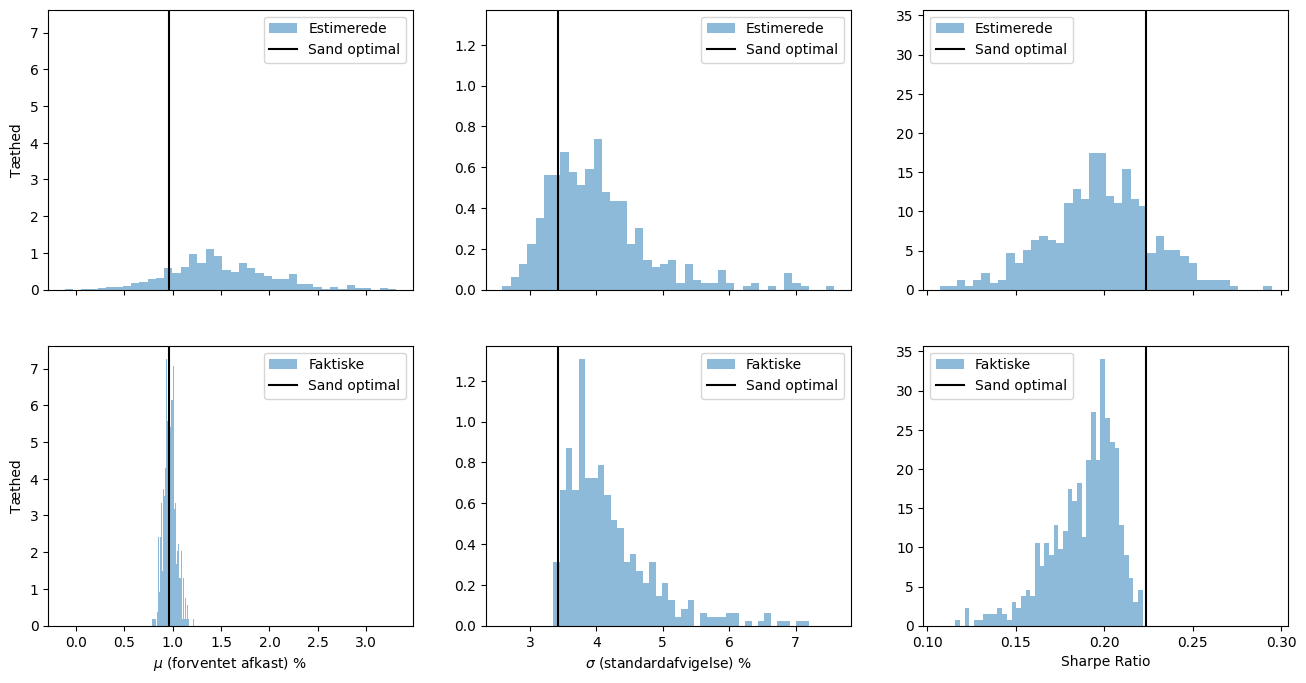

In [554]:
# plot histogram of estimated and actual expected return and std. for simulated portfolios + true optimal

# LAV OGSÅ EN MED SHARPE RATIO FOR ALLE SIMULATIONER ESTIMERET OG FAKTISK (faktisk bør alle være under den sande) sammen med den sande

fig, ax = plt.subplots(2,3,figsize=(16,8), sharex='col', sharey='col')

# expected return
ax[0,0].hist(mu_sim_est, alpha=0.5,
        label="Estimerede", bins=40, density=True)
ax[0,0].axvline(mu_m, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[0,0].legend()
ax[1,0].hist(mu_sim, alpha=0.5,
        label="Faktiske", bins=40, density=True)
ax[1,0].axvline(mu_m, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[1,0].legend()

# std.
ax[0,1].hist(std_sim_est, alpha=0.5,
        label="Estimerede", bins=40, density=True)
ax[0,1].axvline(std_m, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[0,1].legend()
ax[1,1].hist(std_sim, alpha=0.5,
        label="Faktiske", bins=40, density=True)
ax[1,1].axvline(std_m, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[1,1].legend()

# Sharpe Ratio
ax[0,2].hist((np.array(mu_sim) - rf) / std_sim_est, alpha=0.5,
        label="Estimerede", bins=40, density=True)
ax[0,2].axvline(sr_m, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[0,2].legend()
ax[1,2].hist((np.array(mu_sim) - rf) / std_sim, alpha=0.5,
        label="Faktiske", bins=40, density=True)
ax[1,2].axvline(sr_m, ymin=0, ymax=1, color="black", label='Sand optimal')
ax[1,2].legend()

# labels and ticks
ax[0,0].set_ylabel("Tæthed")
ax[1,0].set_ylabel("Tæthed")
ax[1,0].set_xlabel("$\mu$ (forventet afkast) %")
ax[1,1].set_xlabel("$\sigma$ (standardafvigelse) %")
ax[1,2].set_xlabel("Sharpe Ratio")

plt.savefig("simulation_histograms.jpg",bbox_inches="tight",dpi=300)
plt.show()

In [534]:
# calculate average of estimated return, variance, std. and SR for simulated MV portfolios

av_mu_sim_est = np.mean(mu_sim_est)
print(av_mu_sim_est)
av_var_sim_est = np.mean(var_sim_est)
print(av_var_sim_est)
av_std_sim_est = np.mean(std_sim_est)
print(av_std_sim_est)
sr_sim_est = (av_mu_sim_est - rf) / av_std_sim_est
print(sr_sim_est)

1.4903243709996514
16.823902482440477
4.023981020301057
0.3219206277227259


In [535]:
# calculate average of actual return, variance and SR for simulated portfolios

av_mu_sim = np.mean(mu_sim)
print(av_mu_sim)
av_var_sim = np.mean(var_sim)
print(av_var_sim)
av_std_sim = np.mean(std_sim)
print(av_std_sim)
sr_sim = (av_mu_sim - rf) / av_std_sim
print(sr_sim)

0.9710805452679263
17.87368750538041
4.176999213214318
0.1858172890750081


In [536]:
# calculate average of true return, std. and variance and SR for equally weighted portfolio

mu_eq_port = portfolio_mean(equal_weights, mu)
print(mu_eq_port)
var_eq_port = portfolio_variance(equal_weights, cov_mat)
print(var_eq_port)
std_eq_port = portfolio_std(equal_weights, cov_mat)
print(std_eq_port)
sr_eq_port = (mu_eq_port - rf) / std_eq_port
print(sr_eq_port)

0.9714088541666668
17.391292863733412
4.170286904246926
0.18619509808207918


# Calculate stats for T=100,300,500,1000

In [537]:
# simulate returns for (num_obs) t= 100, 300, 500, 1000 months
# find optimal portfolio weights for each simulation

#rf = 0
num_sim = 500
num_obs = 1000 # months
T = [100, 300, 500, 1000]
np.random.seed(2)
sim_data_t = np.random.multivariate_normal(mu, cov_mat, size=(num_sim, num_obs))

#w_sim_t = np.ndarray([len(T),num_sim,len(mu)])
w_sim_t = list([[],[],[],[]])
j = 0

for t in T:
    mu_est = np.mean(sim_data_t[:,:t,:], axis=1)

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1, 'jac' : lambda w: np.ones_like(w)},
                   {'type': 'ineq', 'fun' : lambda w: w, 'jac' : lambda w: np.eye(len(w))})

    equal_weights = np.ones_like(mu) / len(mu)

    for i in range(num_sim):

        cov_mat_est = np.cov(sim_data_t[i,:t,:], rowvar=False)

        res = minimize(fun = sharpe_ratio, args=(mu_est[i], cov_mat_est, rf),
                       x0 = equal_weights,
                       method = 'SLSQP',
                       constraints = constraints)
        w_sim_t[j].append(res.x)
        #print(res.x)
    j += 1
w_sim_t = np.array(w_sim_t)

In [538]:
# calculate ESTIMATED expected portfolio returns, std. and variances for simulated MV portfolios T=100,300,500,1000

mu_sim_est_t = np.ndarray([len(T),num_sim])
var_sim_est_t = np.ndarray([len(T),num_sim])
j = 0

for t in T:
    mu_est = np.mean(sim_data[:,:t,:], axis=1)
    for i in range (num_sim):
        mean = portfolio_mean(w_sim_t[j,i], mu_est[i])
        cov_mat_est = np.cov(sim_data[i,:t,:], rowvar=False)
        var = portfolio_variance(w_sim_t[j,i], cov_mat_est)
        mu_sim_est_t[j,i] = mean
        var_sim_est_t[j,i] = var
    j += 1

std_sim_est_t = np.sqrt(var_sim_est_t)

In [539]:
# calculate ACTUAL expected portfolio returns, std. and variance for the simulated MV portfolios

mu_sim_t = np.ndarray([len(T),num_sim])
var_sim_t = np.ndarray([len(T),num_sim])
j = 0

for t in T:
    for i in range (num_sim):
        mean = portfolio_mean(w_sim_t[j,i], mu)
        var = portfolio_variance(w_sim_t[j,i], cov_mat)
        mu_sim_t[j,i] = mean
        var_sim_t[j,i] = var
    j +=1

std_sim_t = np.sqrt(var_sim_t)

In [540]:
# calculate average of actual return, variance and SR for simulated portfolios

av_mu_sim_t = np.ndarray([4,1])
av_std_sim_t = np.ndarray([4,1])
sr_sim_t = np.ndarray([4,1])

for t in range(len(T)):
    av_mu_sim_t[t] = np.mean(mu_sim_t[t])
    print(av_mu_sim_t[t])
    #av_var_sim = np.mean(var_sim)
    #print(av_var_sim)
    av_std_sim_t[t] = np.mean(std_sim_t[t])
    print(av_std_sim_t[t])
    sr_sim_t[t] = (av_mu_sim_t[t] - rf) / av_std_sim_t[t]
    print(sr_sim_t[t])

[0.97234666]
[4.03600121]
[0.19262254]
[0.97076091]
[3.78494407]
[0.20498032]
[0.96736375]
[3.67189403]
[0.21036606]
[0.96403493]
[3.56819408]
[0.21554687]


In [541]:
sr_sim_t

array([[0.19262254],
       [0.20498032],
       [0.21036606],
       [0.21554687]])

In [542]:
# Make stats dataframe with mean and std. of estimated optimal portfolio parameters
# and actual optimal portfolio parameters

stats_table = pd.DataFrame(columns=['True Optimal', '60', '100', '300', '500', '1000'])

#portfolio weights
for i in range(len(mu)):
    stats_table.loc["$x_{}$".format(i+1),'True Optimal'] = np.round(np.abs(w_m[i]),3)
    stats_table.loc["$x_{}$".format(i+1),'60'] = np.round(np.mean(w_sim[:,i]),3)
    stats_table.loc["std_{}".format(i+1),'60'] = np.round(np.std(w_sim[:,i]),3)
    stats_table.loc["$x_{}$".format(i+1),'100'] = np.round(np.mean(w_sim_t[0,:,i]),3)
    stats_table.loc["std_{}".format(i+1),'100'] = np.round(np.std(w_sim_t[0,:,i]),3)
    stats_table.loc["$x_{}$".format(i+1),'300'] = np.round(np.mean(w_sim_t[1,:,i]),3)
    stats_table.loc["std_{}".format(i+1),'300'] = np.round(np.std(w_sim_t[1,:,i]),3)
    stats_table.loc["$x_{}$".format(i+1),'500'] = np.round(np.mean(w_sim_t[2,:,i]),3)
    stats_table.loc["std_{}".format(i+1),'500'] = np.round(np.std(w_sim_t[2,:,i]),3)
    stats_table.loc["$x_{}$".format(i+1),'1000'] = np.round(np.mean(w_sim_t[3,:,i]),3)
    stats_table.loc["std_{}".format(i+1),'1000'] = np.round(np.std(w_sim_t[3,:,i]),3)

#expected portfolio return
stats_table.loc["$\mu$",'True Optimal'] = np.round(mu_m,3)
stats_table.loc["$\mu$",'60'] = np.round(np.mean(mu_sim_est),3)
stats_table.loc["std mu",'60'] = np.round(np.std(mu_sim_est),3)
stats_table.loc["$\mu$",'100'] = np.round(np.mean(mu_sim_est_t[0]),3)
stats_table.loc["std mu",'100'] = np.round(np.std(mu_sim_est_t[0]),3)
stats_table.loc["$\mu$",'300'] = np.round(np.mean(mu_sim_est_t[1]),3)
stats_table.loc["std mu",'300'] = np.round(np.std(mu_sim_est_t[1]),3)
stats_table.loc["$\mu$",'500'] = np.round(np.mean(mu_sim_est_t[2]),3)
stats_table.loc["std mu",'500'] = np.round(np.std(mu_sim_est_t[2]),3)
stats_table.loc["$\mu$",'1000'] = np.round(np.mean(mu_sim_est_t[3]),3)
stats_table.loc["std mu",'1000'] = np.round(np.std(mu_sim_est_t[3]),3)

#portfolio variance
stats_table.loc["$\sigma$",'True Optimal'] = np.round(std_m,3)
stats_table.loc["$\sigma$",'60'] = np.round(np.mean(std_sim_est),3)
stats_table.loc["std sigma",'60'] = np.round(np.std(std_sim_est),3)
stats_table.loc["$\sigma$",'100'] = np.round(np.mean(std_sim_est_t[0]),3)
stats_table.loc["std sigma",'100'] = np.round(np.std(std_sim_est_t[0]),3)
stats_table.loc["$\sigma$",'300'] = np.round(np.mean(std_sim_est_t[1]),3)
stats_table.loc["std sigma",'300'] = np.round(np.std(std_sim_est_t[1]),3)
stats_table.loc["$\sigma$",'500'] = np.round(np.mean(std_sim_est_t[2]),3)
stats_table.loc["std sigma",'500'] = np.round(np.std(std_sim_est_t[2]),3)
stats_table.loc["$\sigma$",'1000'] = np.round(np.mean(std_sim_est_t[3]),3)
stats_table.loc["std sigma",'1000'] = np.round(np.std(std_sim_est_t[3]),3)

stats_table

,True Optimal,60,100,300,500,1000
$x_1$,0.199,0.151,0.166,0.175,0.179,0.182
std_1,NaN,0.251,0.247,0.209,0.196,0.155
$x_2$,0.0,0.036,0.022,0.011,0.004,0.001
std_2,NaN,0.104,0.07,0.036,0.019,0.006
$x_3$,0.0,0.042,0.039,0.038,0.028,0.019
std_3,NaN,0.145,0.112,0.096,0.074,0.056
$x_4$,0.007,0.101,0.08,0.057,0.049,0.037
std_4,NaN,0.181,0.141,0.093,0.079,0.055
$x_5$,0.095,0.096,0.096,0.095,0.088,0.089
std_5,NaN,0.162,0.169,0.118,0.098,0.085


In [543]:
a2l.to_ltx(stats_table,frmt='{:3.3f}', arraytype = 'bmatrix', print_out=True)

\begin{bmatrix}
 $x_1$ &  0.199 &  0.151 &  0.166 &  0.175 &  0.179 &  0.182\\
 std_1 &  nan  &  0.251 &  0.247 &  0.209 &  0.196 &  0.155\\
 $x_2$ &  0.000 &  0.036 &  0.022 &  0.011 &  0.004 &  0.001\\
 std_2 &  nan  &  0.104 &  0.070 &  0.036 &  0.019 &  0.006\\
 $x_3$ &  0.000 &  0.042 &  0.039 &  0.038 &  0.028 &  0.019\\
 std_3 &  nan  &  0.145 &  0.112 &  0.096 &  0.074 &  0.056\\
 $x_4$ &  0.007 &  0.101 &  0.080 &  0.057 &  0.049 &  0.037\\
 std_4 &  nan  &  0.181 &  0.141 &  0.093 &  0.079 &  0.055\\
 $x_5$ &  0.095 &  0.096 &  0.096 &  0.095 &  0.088 &  0.089\\
 std_5 &  nan  &  0.162 &  0.169 &  0.118 &  0.098 &  0.085\\
 $x_6$ &  0.000 &  0.021 &  0.012 &  0.003 &  0.000 &  0.000\\
 std_6 &  nan  &  0.076 &  0.051 &  0.018 &  0.002 &  0.001\\
 $x_7$ &  0.148 &  0.110 &  0.123 &  0.131 &  0.142 &  0.147\\
 std_7 &  nan  &  0.201 &  0.207 &  0.173 &  0.157 &  0.130\\
 $x_8$ &  0.249 &  0.192 &  0.219 &  0.234 &  0.242 &  0.241\\
 std_8 &  nan  &  0.261 &  0.266 &  0.210 &  0

# Plot results in graph with true efficient frontier

In [550]:
# find minimum variance portfolio

constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1, 'jac' : lambda w: np.ones_like(w)},
               {'type': 'ineq', 'fun' : lambda w: w, 'jac' : lambda w: np.eye(len(w))})

# set initial value
equal_weights = np.ones_like(mu) / len(mu)

res = minimize(fun = portfolio_variance, args=(cov_mat),
               x0 = equal_weights,
               method = 'SLSQP',
               constraints = constraints,
               options={'ftol': 1e-9, 'disp': True})
w_mv = res.x
print(np.round(w_mv,4))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11.047705854878476
            Iterations: 12
            Function evaluations: 137
            Gradient evaluations: 12
[ 0.2732 -0.      0.      0.      0.      0.0164  0.1349  0.1826  0.3929
 -0.    ]


In [545]:
mu_mv = portfolio_mean(w_mv, mu)
std_mv = np.sqrt(portfolio_variance(w_mv, cov_mat))

# tangency portfolio
w_max_sr = w_m

mu_max_sr = mu_m
std_max_sr = std_m

# efficient portfolios
alpha = np.linspace(-5.0, 1.0, 1000)

w_eff = w_mv[:, None] * alpha[None, :] + w_max_sr[:, None] * (1-alpha[None, :])

std_eff = np.apply_along_axis(portfolio_std, 0, w_eff, (cov_mat))
mu_eff = np.apply_along_axis(portfolio_mean, 0, w_eff, (mu))

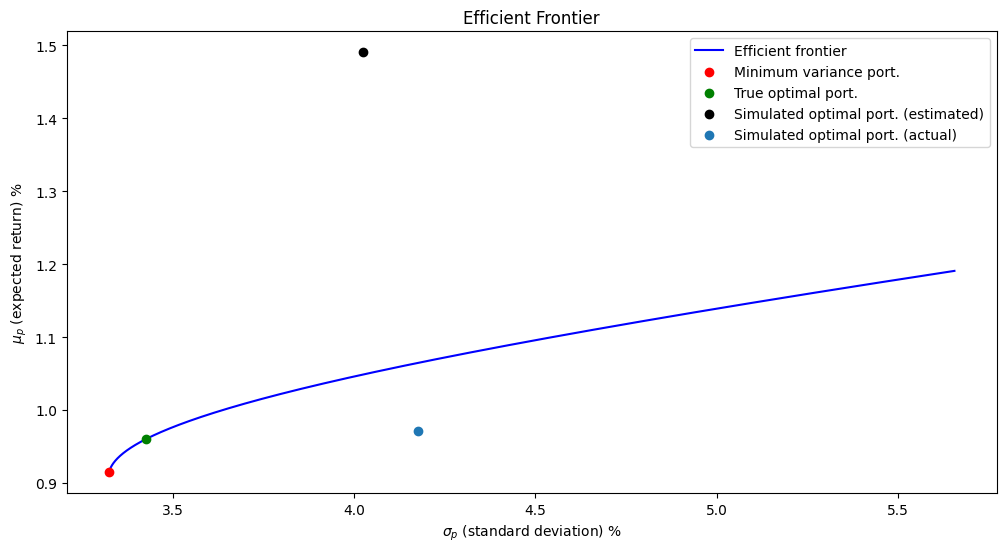

In [546]:
"""
Plot the efficient frontier
"""
rf = 0
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(std_eff, mu_eff, color="blue", label="Efficient frontier")
#ax.plot([0.0, std_max_sr], [rf, mu_max_sr], color="gray", linestyle="--")
ax.scatter(std_mv, mu_mv, color="red", label="Minimum variance port. ", zorder=10)
ax.scatter(std_max_sr, mu_max_sr, color="green", label="True optimal port. ", zorder=10)
ax.scatter(av_std_sim_est, av_mu_sim_est, color="black", label="Simulated optimal port. (estimated)")
ax.scatter(av_std_sim, av_mu_sim, label="Simulated optimal port. (actual)")
#ax.scatter(0, rf, color="y", label="Risk free rate", zorder=10)

ax.set_title("Efficient Frontier")
ax.set_xlabel("$\sigma_p$ (standard deviation) %")
ax.set_ylabel("$\mu_p$ (expected return) %")

ax.legend();

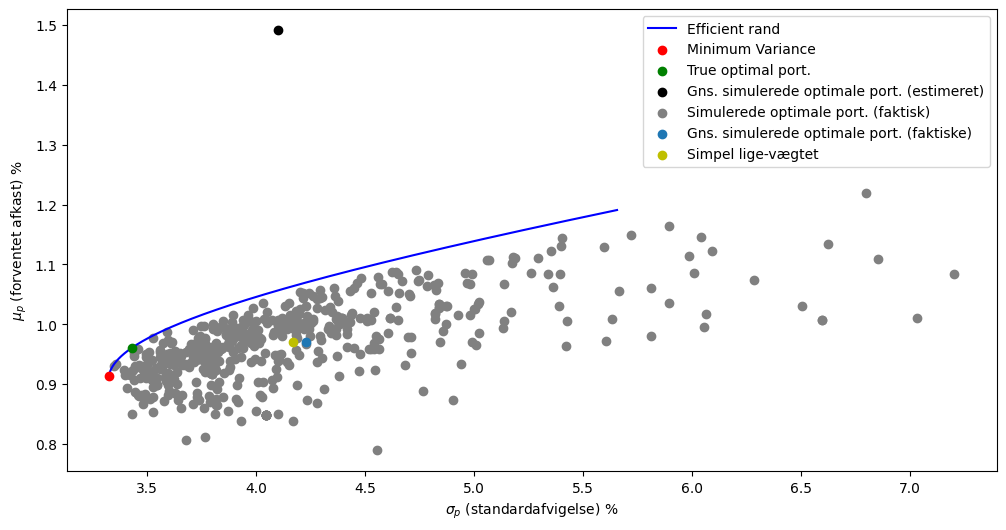

In [553]:
"""
plot efficient frontier with simulated portfolios
"""
rf = rf_est
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(std_eff, mu_eff, color="blue", label="Efficient rand")
#ax.plot([0.0, std_max_sr], [rf, mu_max_sr], color="black", linestyle="--", label="Sharpe efficiente port.")
ax.scatter(std_mv, mu_mv, color="red", label="Minimum Variance", zorder=10)
ax.scatter(std_max_sr, mu_max_sr, color="green", label="True optimal port. ", zorder=10)
ax.scatter(np.sqrt(av_var_sim_est), av_mu_sim_est, color="black", label="Gns. simulerede optimale port. (estimeret)")
ax.scatter(np.sqrt(var_sim), mu_sim,color="grey", label="Simulerede optimale port. (faktisk)")
#ax.scatter(0, rf, color="y", label="Risikofri rente", zorder=10)
ax.scatter(np.sqrt(av_var_sim), av_mu_sim, label="Gns. simulerede optimale port. (faktiske)")
ax.scatter(np.sqrt(var_eq_port), mu_eq_port, color="y", label="Simpel lige-vægtet", zorder=10)
#ax.scatter(np.sqrt(var_sim_est), mu_sim_est, label="Gns. simulerede optimale port. (estimerede)")
#ax.scatter(mu_sim, mu_sim_est, label="test mu")
#ax.scatter(np.sqrt(var_sim_est), np.sqrt(var_sim), label="test std.")

ax.set_xlabel("$\sigma_p$ (standardafvigelse) %")
ax.set_ylabel("$\mu_p$ (forventet afkast) %")

ax.legend()
plt.savefig("efficient_frontier_w_simulations.jpg",bbox_inches="tight",dpi=300)
plt.show()

# Print tables to Latex

In [548]:
np.array(list(assets))

array(['NoDur', 'Durbl', 'Manuf', 'Enrgy', 'HiTec', 'Telcm', 'Shops',
       'Hlth', 'Utils', 'Other'], dtype='<U5')

In [549]:
a2l.to_ltx(pd.DataFrame(assets).T, arraytype = 'bmatrix', print_out=True)
a2l.to_ltx(np.array(mu), frmt = '{:6.2f}', arraytype = 'bmatrix', print_out=True)
a2l.to_ltx(np.tril(cov_mat), frmt = '{:6.2f}', arraytype = 'bmatrix', print_out=True)
a2l.to_ltx(w_m, frmt = '{:6.3f}', arraytype = 'bmatrix', print_out=True)

\begin{bmatrix}
 0 &  NoDur &  Durbl &  Manuf &  Enrgy &  HiTec &  Telcm &  Shops &  Hlth &  Utils &  Other
\end{bmatrix}
\begin{bmatrix}
    0.92 &    1.04 &    1.03 &    1.01 &    1.22 &    0.69 &    1.01 &    1.00 &    0.85 &    0.95
\end{bmatrix}
\begin{bmatrix}
   14.40 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00\\
   15.26 &   64.99 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00\\
   13.53 &   28.89 &   23.42 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00\\
   11.79 &   23.83 &   20.02 &   43.54 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00\\
   11.70 &   33.01 &   22.96 &   16.87 &   46.22 &    0.00 &    0.00 &    0.00 &    0.00 &    0.00\\
   11.60 &   22.12 &   16.68 &   15.34 &   22.94 &   25.79 &    0.00 &    0.00 &    0.00 &    0.00\\
   12.01 &   25.93 &   17.28 &   12.28 &   21.70 &   15.16 &   21.30 &    0.00 &    0.00 &    0.00\\
   10.82 &   15.04 &   12.